# HMM for Bach Chorales

Based on 
https://pyro.ai/examples/hmm.html



In [2]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [3]:
from jax.config import config

config.update("jax_debug_nans", False)

## Imports

In [4]:
from IPython.utils import io

with io.capture_output() as captured:
    !pip install distrax
    !pip install numpyro
    !pip install chex

import warnings

warnings.filterwarnings("ignore")

In [5]:
try:
    import ssm_jax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    import ssm_jax

In [6]:
import jax.numpy as jnp
from jax import vmap
from jax.nn import sigmoid

import tensorflow_probability as tfp
import distrax
import optax
from numpyro.examples.datasets import JSB_CHORALES, load_dataset

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ssm_jax.hmm.models import BernoulliHMM
from ssm_jax.hmm.learning import hmm_fit_sgd

## Load Training Dataset

In [7]:
_, fetch = load_dataset(JSB_CHORALES, split="train", shuffle=False)

lengths, sequences_all = fetch()

# find all the notes that are present at least once in the training set
present_notes = (sequences_all == 1).sum(0).sum(0) > 0
# remove notes that are never played (we remove 37/88 notes with default args)
sequences = sequences_all[..., present_notes]

print(sequences_all.shape)
print(sequences.shape)
print(lengths)

(229, 129, 88)
(229, 129, 51)
[129  65  49  65 114  33  57  49  64  33 108  48  49  48  61  48  65  53
  41  52  33  61  41  45  69  39  57  80  86  57  61 105  68  65  48  57
  57  52  48  33  93  41  65  49  73  48  33  45  65  52  49 109  49  52
  65  41  49  65  77  73  57  41  65  57  44  33  85  72  60  41  49  33
  56  52  56  83  57  57  52  41  53  64  61  65  65  48  25  96  41  37
  76  65  65  72  41  65  41  37  77  48  85  57  72  48  45  53  49  84
  68  49  73  50  96  55  66  98  37  76  65  33  49  77  76  65 128  41
  45  61  33  88  61  63  65  68  60  49  48  45  65  45  33  64  64  65
  49  63  61  48  45  65  84 120  41 102  49  57  69  57  82  48  76  48
  52 113  97  83  33  68  41  49  65 109 108  60  65  57  49  33  57  33
  61 113  58  64  65  33  57  49  64  68  60  65  41  72  53  49  57  33
  49  89  65  44  49  61  65  69  52  76  33  57  76  57  33  76 101  40
  41  44  76  65  49  54  49  49  64  51 109  65  65]


### Present Notes

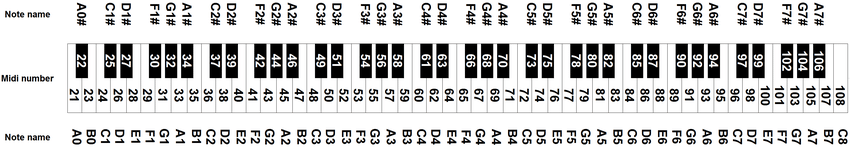

https://www.researchgate.net/figure/88-notes-classical-keyboard-Note-names-and-MIDI-numbers_fig8_283460243

In [8]:
sequences.shape

(229, 129, 51)

In [9]:
print(jnp.where(present_notes)[0])

[22 25 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75]


### Visualization of Training Sequences

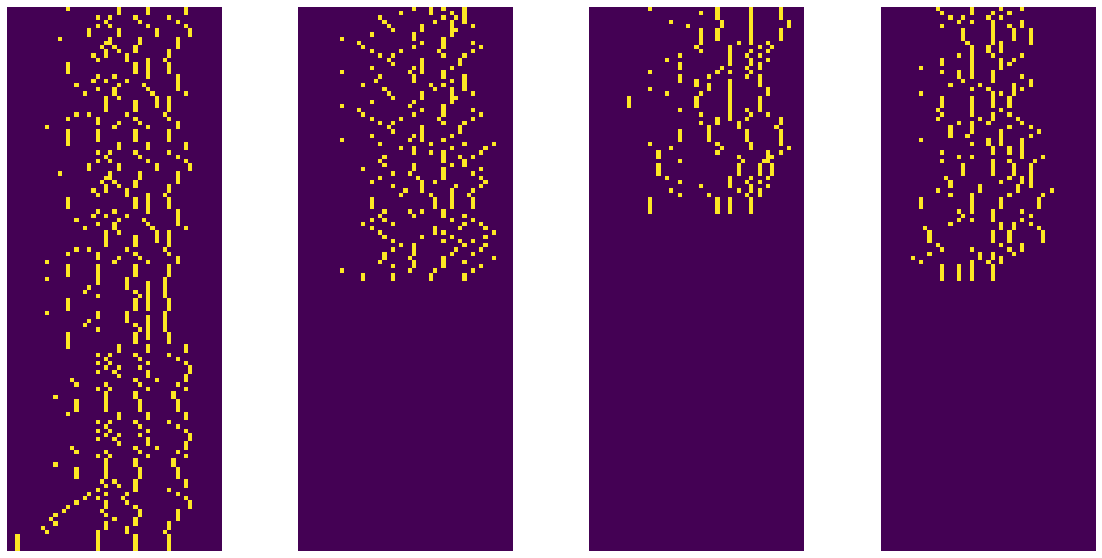

In [10]:
N = 4
fig, axs = plt.subplots(1, N, figsize=(20, 10))
axs = axs.reshape(N)
for i in range(N):
    X = sequences[i, :, :].squeeze()
    ax = axs[i]
    ax.imshow(X)
    ax.set_axis_off()
plt.show()

## Gradient Descent Implementation

## Initialize HMM

In [11]:
def init_hmm(K: int, D: int, initial_prob: float = 0.1, seed: int = 1):
    dirichlet_dist = tfp.substrates.jax.distributions.Dirichlet(0.9 * jnp.eye(K) + 0.1)

    initial_probabilities = jnp.ones((K,)) / K * 1.0
    transition_matrix = distrax.as_distribution(dirichlet_dist).sample(seed=seed)
    emission_probs = jnp.full((K, D), initial_prob)

    initial_hmm = BernoulliHMM(initial_probabilities, transition_matrix, emission_probs)
    return initial_hmm

## Model Selection

### Determine Hyperparameters

In [12]:
num_epochs = 50
batch_size = 20

In [13]:
hidden_states = [4, 8, 16, 24]
batch_sizes = [1, 20, 229]
learning_rates = [1e-4, 5e-2, 5e-2]

D = sequences.shape[-1]

In [14]:
len(sequences)

229

In [16]:
all_models, all_losses, all_obs_logits = {}, [], []

for learning_rate, batch_size in zip(learning_rates, batch_sizes):
    optimizer = optax.adam(learning_rate)
    models = {}
    losses, obs_logits = [], []
    for k in hidden_states:
        initial_hmm = init_hmm(k, D)
        hmm, loss_ = hmm_fit_sgd(
            initial_hmm, sequences, lengths, optimizer=optimizer, batch_size=batch_size, num_iters=num_epochs
        )
        # Store results
        models[k] = hmm
        losses.append(loss_)
        obs_logits.append(jnp.log(hmm.emission_probs.value))

    all_models[batch_size] = models
    all_losses.append(losses)
    all_obs_logits.append(obs_logits)

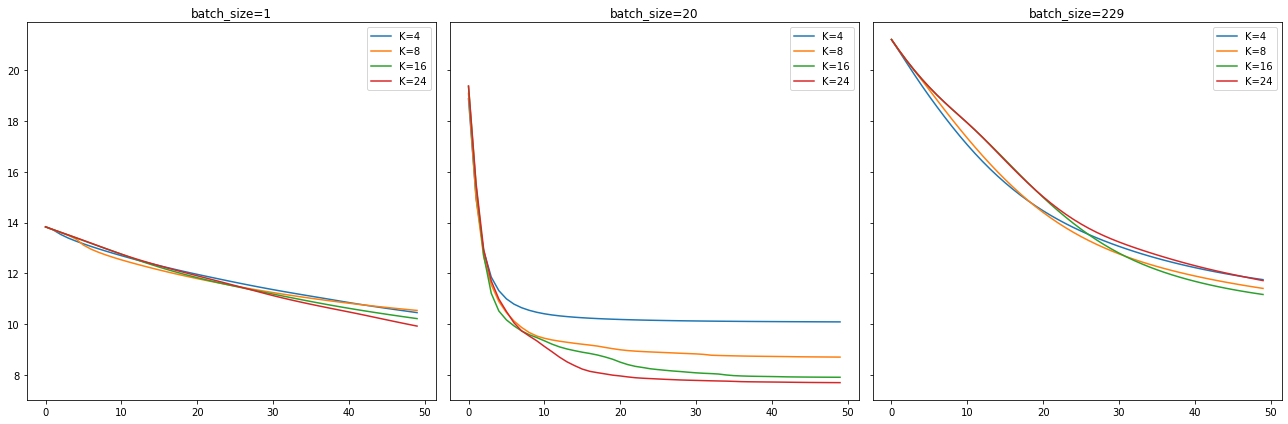

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=len(batch_sizes), sharey=True)
axes = np.array(axes)

fig.set_figheight(6)
fig.set_figwidth(18)

for b, (batch_size, ax) in enumerate(zip(batch_sizes, axes.flatten())):
    for h, k in enumerate(hidden_states):
        ax.plot(all_losses[b][h], label=f"K={k}")

    ax.set_title(f"batch_size={batch_size}")
    ax.legend(loc="upper right")


fig.tight_layout()
plt.show()

## Visualization of Parameters of HMM

In [18]:
def plot_observation_dist(idx, batch_sizes, all_obs_logits):
    fig, axes = plt.subplots(nrows=1, ncols=len(batch_sizes))
    fig.set_figwidth(20)
    fig.set_figwidth(24)
    for b, (batch_size, ax) in enumerate(zip(batch_sizes, axes.flatten())):
        im = ax.imshow(sigmoid(all_obs_logits[b][idx]))
        ax.set_title(f"batch_size={batch_size}")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        plt.colorbar(im, cax=cax)

    fig.tight_layout()
    plt.show()

In [19]:
# @title Select the Number of Hidden States

K = 16  # [4, 8, 16, 24]
i = np.where(np.array(hidden_states) == K)[0][0]

### Observation Distribution

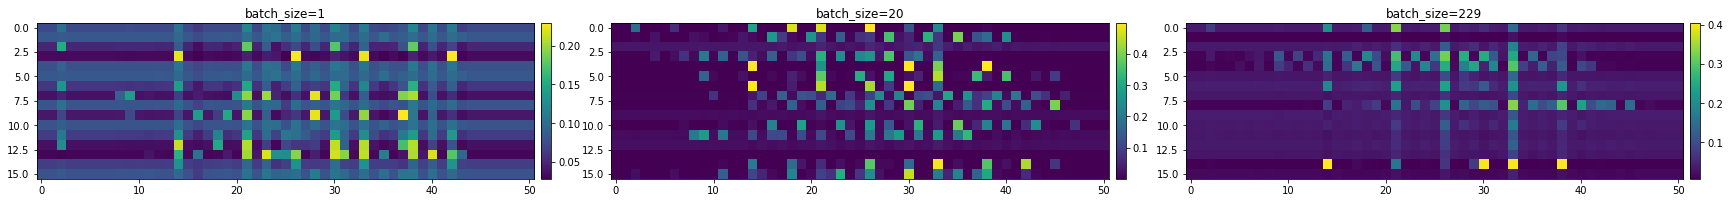

In [20]:
plot_observation_dist(i, batch_sizes, all_obs_logits)

### Transition Probabilities

In [23]:
def plot_transition_probs(n_hidden, batch_sizes, all_obs_logits):
    fig, axes = plt.subplots(nrows=1, ncols=len(batch_sizes))
    fig.set_figwidth(20)

    for batch_size, ax in zip(batch_sizes, axes.flatten()):
        im = ax.imshow(sigmoid(all_models[batch_size][n_hidden].transition_matrix.value))
        ax.set_title(f"batch_size={batch_size}")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im, cax=cax)

    fig.tight_layout()
    plt.show()

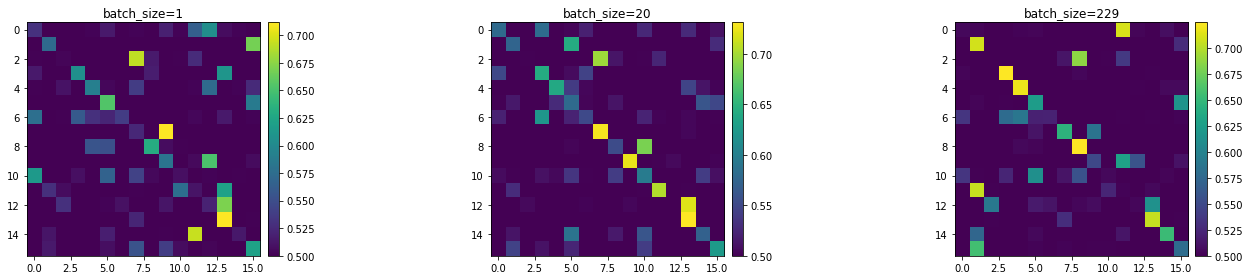

In [24]:
n_hidden = hidden_states[i]
plot_transition_probs(n_hidden, batch_sizes, all_models)

## Model Selection

### Load Test Dataset

In [25]:
_, fetch = load_dataset(JSB_CHORALES, split="test", shuffle=False)

In [26]:
test_lengths, test_sequences = fetch()

# find all the notes that are present at least once in the training set
test_sequences = test_sequences[..., present_notes]

In [27]:
def neg_log_likelihood(hmm, batch_emissions):
    f = lambda emissions: -hmm.marginal_log_prob(emissions) / len(emissions)
    return vmap(f)(batch_emissions).mean()

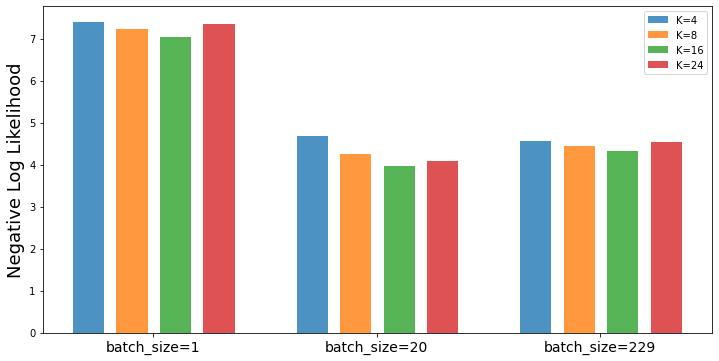

In [28]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
plt.figure(figsize=(12, 6))
ax = plt.gca()
negative_log_likelihoods = []

for b, (batch_size) in enumerate(batch_sizes):
    nlls = jnp.array([])
    for h, (k, color) in enumerate(zip(hidden_states, colors)):
        nll = neg_log_likelihood(all_models[batch_size][k], test_sequences)
        nlls = jnp.append(nlls, nll)
        ax.bar(b * 1.8 + h * 0.35, nll, color=color, label=f"K={k}" if b == 0 else None, width=0.25, alpha=0.8)
    negative_log_likelihoods.append(nlls)

plt.xticks(
    [b * 1.8 + 0.52 for b in range(len(batch_sizes))],
    [f"batch_size={batch_size}" for batch_size in batch_sizes],
    fontsize=14,
)
plt.ylabel("Negative Log Likelihood", fontsize=18)
ax.legend(loc="upper right")
plt.show()

## Best Model

In [29]:
negative_log_likelihoods = np.vstack(negative_log_likelihoods)
best_batch_idx, best_hidden_idx = np.unravel_index(negative_log_likelihoods.argmin(), negative_log_likelihoods.shape)
best_batch_size, best_n_hidden = batch_sizes[best_batch_idx], hidden_states[best_hidden_idx]

In [30]:
print(f"Best Model : batch_size={best_batch_size}, K={best_n_hidden}")
print(f"Test Negative Loglikelihood of Best Model : {negative_log_likelihoods[best_batch_idx][best_hidden_idx]}")

Best Model : batch_size=20, K=16
Test Negative Loglikelihood of Best Model : 3.9587671756744385


### Visualization of Parameters of the Best HMM

#### Observation Distribution

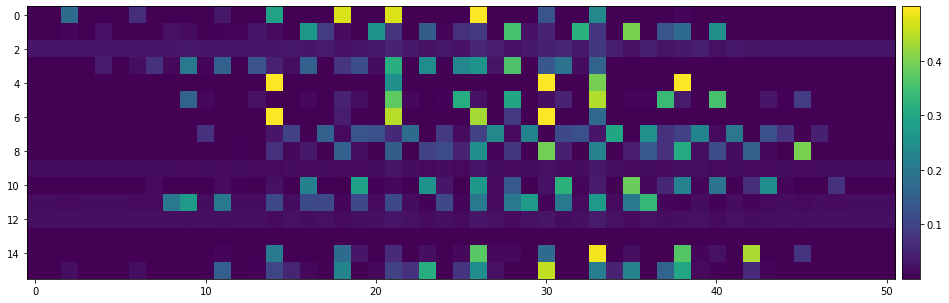

In [31]:
plt.figure(figsize=(16, 16))
ax = plt.gca()
im = plt.imshow(sigmoid(all_obs_logits[best_batch_idx][best_hidden_idx]))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

plt.colorbar(im, cax=cax);

#### Transition Probabilities

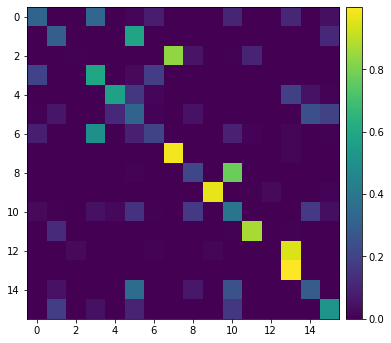

In [33]:
plt.figure(figsize=(6, 6))
ax = plt.gca()
im = plt.imshow(all_models[best_batch_size][best_n_hidden].transition_matrix.value)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

plt.colorbar(im, cax=cax);